# Adjusting Monthly Targets to a Daily Level

Targets are usually provided on a monthly, quarterly, or yearly level.
However, when tracking performance, we want to see if we are on track to meet
our targets on a daily basis, not at the end of the month, quarter or year, in
order to make adjustments in time.
<br />
This notebook demonstrates how to adjust monthly targets to a daily level
using the Walmart sales dataset. It utilizes features such as holidays,
day of the week, and other calendar features to create a daily target
dataset, based on the monthly targets and on the historical sales data.

## Imports

In [123]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
import optuna
from datetime import datetime, timedelta
import humanize
from sklearn import metrics
from sklearn.tree import plot_tree
import joblib

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.ticker as ticker

## Visualization Setup and Helper Functions

In [101]:
font_path = '/usr/share/fonts/noto_sans_mono/NotoSansMono_SemiCondensed-SemiBold.ttf'
font_prop = fm.FontProperties(fname=font_path)

sns.set_theme(
    style='darkgrid',
    context='notebook',
    font=font_prop.get_name(),
    rc={
        'font.weight': 'semibold',
        'axes.labelweight': 'semibold',
        'axes.titlesize': 'large',
        'axes.titleweight': 'semibold',
        'axes.labelsize': 'medium',
        }
    )

In [108]:
# Returns the x coordinates of a text element on a given axis of a given
# figure.
# Used to position elements on the canvas
# Returns object with attributes:
#   x0 coordinate of the text element
#   x1 coordinate of the text element
#   y0 coordinate of the text element
#   y1 coordinate of the text element
def get_text_coordinates(text_element, ax, fig):
        x0 = text_element.get_window_extent(fig.canvas.get_renderer()).x0
        x1 = text_element.get_window_extent(fig.canvas.get_renderer()).x1
        y0 = text_element.get_window_extent(fig.canvas.get_renderer()).y0
        y1 = text_element.get_window_extent(fig.canvas.get_renderer()).y1
        return {
                 'x0': round(ax.transData.inverted().transform_point((x0, 0))[0], 2),
                 'x1': round(ax.transData.inverted().transform_point((x1, 0))[0], 2),
                 'y0': round(ax.transData.inverted().transform_point((0, y0))[1], 2),
                 'y1': round(ax.transData.inverted().transform_point((0, y1))[1], 2)
               }

## Load Data

In [2]:
# Source https://www.kaggle.com/datasets/devarajv88/walmart-sales-dataset
pd.read_csv('data/sales_train_validation.csv')

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [3]:
pd.read_csv('data/sales_train_evaluation.csv')

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [4]:
pd.read_csv('data/calendar.csv')

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [5]:
pd.read_csv('data/sell_prices.csv')

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [6]:
prices_df = pd.read_csv('data/sell_prices.csv')
sales_df = pd.read_csv('data/sales_train_validation.csv')

In [7]:
d_cols = [f'd_{i}' for i in range(1, 1914)]

Melt the sales dataframe to have a long format with one row per item per day.
Then join with the calendar dataframe to get the date and other calendar
features, join to get the prices and sum up to get the GMV.

In [8]:
def melt_sales_df(df):
    melted_df = pd.melt(
            df,
            id_vars=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
            value_vars=[f'd_{i}' for i in range(1, 1914)],
            var_name='day', value_name='sales'
            )

    return melted_df

In [9]:
melted_sales_df = melt_sales_df(sales_df)

In [10]:
melted_sales_df

,item_id,dept_id,cat_id,store_id,state_id,day,sales
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...
58327365,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1
58327366,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327367,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327368,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3


In [11]:
calendar_df = pd.read_csv('data/calendar.csv')
calendar_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [12]:
# Merge the melted sales dataframe with the calendar dataframe
merged_df = pd.merge(
    melted_sales_df,
    calendar_df[['d', 'date', 'wday', 'month', 'year', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']],
    left_on='day',
    right_on='d'
)

merged_df.drop(columns=['d'], inplace=True)
merged_df

,item_id,dept_id,cat_id,store_id,state_id,day,sales,date,wday,month,year,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,11101,NaN,NaN,NaN,NaN
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,11101,NaN,NaN,NaN,NaN
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,11101,NaN,NaN,NaN,NaN
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,11101,NaN,NaN,NaN,NaN
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011,11101,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,2,4,2016,11613,NaN,NaN,NaN,NaN
58327366,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,2,4,2016,11613,NaN,NaN,NaN,NaN
58327367,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,2,4,2016,11613,NaN,NaN,NaN,NaN
58327368,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,2,4,2016,11613,NaN,NaN,NaN,NaN


In [13]:
# Merge the merged dataframe with the prices dataframe
merged_df_with_prices = pd.merge(
    merged_df,
    prices_df[['store_id', 'item_id', 'sell_price', 'wm_yr_wk']],
    on=['store_id', 'item_id', 'wm_yr_wk']
)

merged_df_with_prices

,item_id,dept_id,cat_id,store_id,state_id,day,sales,date,wday,month,year,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,sell_price
0,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,1,1,2011,11101,NaN,NaN,NaN,NaN,0.46
1,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,2,1,2011,11101,NaN,NaN,NaN,NaN,0.46
2,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,3,1,2011,11101,NaN,NaN,NaN,NaN,0.46
3,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,4,2,2011,11101,NaN,NaN,NaN,NaN,0.46
4,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,5,2,2011,11101,NaN,NaN,NaN,NaN,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,2,4,2016,11613,NaN,NaN,NaN,NaN,3.98
46027953,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1912,1,2016-04-23,1,4,2016,11613,NaN,NaN,NaN,NaN,1.28
46027954,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,2,4,2016,11613,NaN,NaN,NaN,NaN,1.28
46027955,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1912,0,2016-04-23,1,4,2016,11613,NaN,NaN,NaN,NaN,1.00


<IPython.core.display.Javascript object>

In [14]:
merged_df_with_prices.isna().sum()

item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
day                    0
sales                  0
date                   0
wday                   0
month                  0
year                   0
wm_yr_wk               0
event_name_1    42341567
event_type_1    42341567
event_name_2    45933474
event_type_2    45933474
sell_price             0
dtype: int64

In [15]:
merged_df_with_prices['gmv'] = merged_df_with_prices['sales'] * merged_df_with_prices['sell_price']

In [16]:
agg_df = merged_df_with_prices.groupby('date').agg({
    'gmv': 'sum',
    'event_name_1': lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan,
    'event_type_1': lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan,
    'event_name_2': lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan,
    'event_type_2': lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan,
    'month': 'first',
    'year': 'first',
    'wday': 'first'
    }).reset_index()

agg_df

,date,gmv,event_name_1,event_type_1,event_name_2,event_type_2,month,year,wday
0,2011-01-29,81650.61,NaN,NaN,NaN,NaN,1,2011,1
1,2011-01-30,78970.57,NaN,NaN,NaN,NaN,1,2011,2
2,2011-01-31,57706.91,NaN,NaN,NaN,NaN,1,2011,3
3,2011-02-01,60761.20,NaN,NaN,NaN,NaN,2,2011,4
4,2011-02-02,46959.95,NaN,NaN,NaN,NaN,2,2011,5
...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,112828.73,NaN,NaN,NaN,NaN,4,2016,5
1909,2016-04-21,110410.27,NaN,NaN,NaN,NaN,4,2016,6
1910,2016-04-22,127040.30,NaN,NaN,NaN,NaN,4,2016,7
1911,2016-04-23,155193.67,NaN,NaN,NaN,NaN,4,2016,1


In [17]:
agg_df.isna().sum()

date               0
gmv                0
event_name_1    1759
event_type_1    1759
event_name_2    1909
event_type_2    1909
month              0
year               0
wday               0
dtype: int64

In [18]:
agg_df[~agg_df['event_name_1'].isna()]

,date,gmv,event_name_1,event_type_1,event_name_2,event_type_2,month,year,wday
8,2011-02-06,83497.56,SuperBowl,Sporting,NaN,NaN,2,2011,2
16,2011-02-14,59728.89,ValentinesDay,Cultural,NaN,NaN,2,2011,3
23,2011-02-21,65547.57,PresidentsDay,National,NaN,NaN,2,2011,3
39,2011-03-09,58771.82,LentStart,Religious,NaN,NaN,3,2011,5
46,2011-03-16,60076.33,LentWeek2,Religious,NaN,NaN,3,2011,5
...,...,...,...,...,...,...,...,...,...
1843,2016-02-15,146662.92,PresidentsDay,National,NaN,NaN,2,2016,3
1845,2016-02-17,112600.65,LentWeek2,Religious,NaN,NaN,2,2016,5
1874,2016-03-17,109851.66,StPatricksDay,Cultural,NaN,NaN,3,2016,6
1881,2016-03-24,105668.13,Purim End,Religious,NaN,NaN,3,2016,6


In [19]:
agg_df.groupby('year')['date'].nunique()

year
2011    337
2012    366
2013    365
2014    365
2015    365
2016    115
Name: date, dtype: int64

In [20]:
monthly_df = agg_df.groupby(['year', 'month'])['gmv'].sum().reset_index()
monthly_df

,year,month,gmv
0,2011,1,218328.09
1,2011,2,1925877.70
2,2011,3,2052900.47
3,2011,4,2027413.92
4,2011,5,2002988.04
...,...,...,...
59,2015,12,3605907.42
60,2016,1,3817490.54
61,2016,2,3821898.04
62,2016,3,3976337.84


In [21]:
agg_df_with_monthly = pd.merge(
    agg_df,
    monthly_df,
    on=['year', 'month'],
    suffixes=('', '_monthly')
)

agg_df_with_monthly['monthly_gmv_share'] = agg_df_with_monthly['gmv'] / agg_df_with_monthly['gmv_monthly']

In [22]:
agg_df_with_monthly

,date,gmv,event_name_1,event_type_1,event_name_2,event_type_2,month,year,wday,gmv_monthly,monthly_gmv_share
0,2011-01-29,81650.61,NaN,NaN,NaN,NaN,1,2011,1,218328.09,0.373981
1,2011-01-30,78970.57,NaN,NaN,NaN,NaN,1,2011,2,218328.09,0.361706
2,2011-01-31,57706.91,NaN,NaN,NaN,NaN,1,2011,3,218328.09,0.264313
3,2011-02-01,60761.20,NaN,NaN,NaN,NaN,2,2011,4,1925877.70,0.031550
4,2011-02-02,46959.95,NaN,NaN,NaN,NaN,2,2011,5,1925877.70,0.024384
...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,112828.73,NaN,NaN,NaN,NaN,4,2016,5,3318563.57,0.033999
1909,2016-04-21,110410.27,NaN,NaN,NaN,NaN,4,2016,6,3318563.57,0.033271
1910,2016-04-22,127040.30,NaN,NaN,NaN,NaN,4,2016,7,3318563.57,0.038282
1911,2016-04-23,155193.67,NaN,NaN,NaN,NaN,4,2016,1,3318563.57,0.046765


In [23]:
agg_df_with_monthly.drop(columns=['gmv', 'gmv_monthly'], inplace=True)

In [24]:
agg_df_with_monthly.groupby('year')['date'].nunique()

year
2011    337
2012    366
2013    365
2014    365
2015    365
2016    115
Name: date, dtype: int64

## Prepare Data for Training

In [25]:
train_val_test_df = pd.get_dummies(agg_df_with_monthly[agg_df_with_monthly['year'].isin([2013, 2014, 2015])],
                                   columns=['event_name_1', 'event_type_1',
                                            'event_name_2', 'event_type_2',
                                            'wday', 'month'],
                                   drop_first=True)

# convert boolean columns to int
for col in train_val_test_df.columns:
    if train_val_test_df[col].dtype == 'bool':
        train_val_test_df[col] = train_val_test_df[col].astype(int)


train_val_test_df

,date,year,monthly_gmv_share,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,event_name_1_Eid al-Fitr,event_name_1_EidAlAdha,event_name_1_Father's day,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
703,2013-01-01,2013,0.023429,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
704,2013-01-02,2013,0.031368,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
705,2013-01-03,2013,0.034315,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
706,2013-01-04,2013,0.032415,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
707,2013-01-05,2013,0.041425,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,2015-12-27,2015,0.032423,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1794,2015-12-28,2015,0.027092,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1795,2015-12-29,2015,0.028442,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1796,2015-12-30,2015,0.030214,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
train_val_test_df.groupby('year')['date'].size()

year
2013    365
2014    365
2015    365
Name: date, dtype: int64

In [27]:
train_val_test_df.columns

Index(['date', 'year', 'monthly_gmv_share', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_SuperBowl', 'event_name_1_Thanksgiving',
       'event_name_1_ValentinesDay', 'event_name_1_VeteransDay',
       'event_type_1_National', 'e

In [28]:
train_val_test_df['date'] = pd.to_datetime(train_val_test_df['date'])

train_val_test_df['day_of_month'] = train_val_test_df['date'].dt.day
train_val_test_df['day_of_month_norm'] = (train_val_test_df['day_of_month'] - 1) / 30

train_val_test_df['days_to_last_day'] = train_val_test_df['date'].dt.days_in_month - train_val_test_df['day_of_month']
train_val_test_df['days_to_last_day_norm'] = train_val_test_df['days_to_last_day'] / train_val_test_df['date'].dt.days_in_month

train_val_test_df.drop(columns=['day_of_month', 'days_to_last_day'], inplace=True)

In [29]:
train_val_test_df.columns

Index(['date', 'year', 'monthly_gmv_share', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_SuperBowl', 'event_name_1_Thanksgiving',
       'event_name_1_ValentinesDay', 'event_name_1_VeteransDay',
       'event_type_1_National', 'e

In [30]:
train_df = train_val_test_df[train_val_test_df['year'] == 2013].copy()
val_df = train_val_test_df[train_val_test_df['year'] == 2014].copy()
test_df = train_val_test_df[train_val_test_df['year'] == 2015].copy()

In [31]:
# Create all pairwise interaction terms.
# Since we are using simple models, we will manually create the interaction
# terms to allow the models to learn from them.
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_train = poly.fit_transform(train_df.drop(columns=['date', 'year', 'monthly_gmv_share']))
y_train = train_df['monthly_gmv_share']

X_val = poly.fit_transform(val_df.drop(columns=['date', 'year', 'monthly_gmv_share']))
y_val = val_df['monthly_gmv_share']

X_test = poly.fit_transform(test_df.drop(columns=['date', 'year', 'monthly_gmv_share']))
y_test = test_df['monthly_gmv_share']

## Training

In [32]:
random_state = 42

In [33]:
def run_study(objective, n_trials=100, direction='minimize'):
    started_at = datetime.now()

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    ended_at = datetime.now()

    duration_in_seconds = (ended_at - started_at).total_seconds()

    print("Best parameters:", study.best_params)
    print("Best score:", study.best_value)
    print("Time taken:", humanize.naturaldelta(timedelta(seconds=duration_in_seconds)))

    return study, duration_in_seconds

def trial_evaluation_metric(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred)

In [34]:
def objective_ridge(trial):
    params = {
        'alpha': trial.suggest_float("alpha", 1e-4, 100.0, log=True),  # Regularization strength
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'solver': trial.suggest_categorical("solver", ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }

    model = Ridge(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [35]:
def objective_elastic_net(trial):
    params = {
        'alpha': trial.suggest_float("alpha", 1e-4, 1.0, log=True),
        'l1_ratio': trial.suggest_float("l1_ratio", 0.0, 1.0),
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'selection': trial.suggest_categorical("selection", ['cyclic', 'random'])
    }

    model = ElasticNet(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [36]:
def objective_dt(trial):
    params = {
        'criterion': trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "absolute_error", "poisson"]),
        'max_depth': trial.suggest_int("max_depth", 1, 15),
        'min_samples_split': trial.suggest_int("min_samples_split", 5, 20),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 5, 20),
        'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    model = DecisionTreeRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [37]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'max_depth': trial.suggest_int("max_depth", 2, 30),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 20),
        'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        'bootstrap': trial.suggest_categorical("bootstrap", [True, False]),
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [38]:
def objective_xgb(trial):
    params = {
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'max_depth': trial.suggest_int("max_depth", 3, 20),
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'gamma': trial.suggest_float("gamma", 0, 5),
        'reg_alpha': trial.suggest_float("reg_alpha", 0, 5),
        'reg_lambda': trial.suggest_float("reg_lambda", 0, 5),
    }


    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return trial_evaluation_metric(y_val, y_pred)

In [39]:
studies = [
    ('Ridge', objective_ridge, Ridge),
    ('Elastic Net', objective_elastic_net, ElasticNet),
    ('Decision Tree', objective_dt, DecisionTreeRegressor),
    ('Random Forest', objective_rf, RandomForestRegressor),
    ('XGBoost', objective_xgb, XGBRegressor),
        ]

In [40]:
training_results = []

for name, objective, model_class in studies:
    print(f"Running study for {name}...")
    study, execution_seconds = run_study(objective, n_trials=50)
    training_results.append(
            (name, model_class, study.best_params, execution_seconds)
            )

training_results_df = pd.DataFrame(
    training_results,
    columns=['Model', 'Model Class', 'Best Parameters', 'Execution Seconds']
    )

[I 2025-06-14 11:00:17,834] A new study created in memory with name: no-name-0f7948a0-e708-412e-9960-be70957d94f5


Running study for Ridge...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-14 11:00:17,911] Trial 0 finished with value: 0.0014213038334050057 and parameters: {'alpha': 0.0009762876663863532, 'fit_intercept': True, 'solver': 'cholesky'}. Best is trial 0 with value: 0.0014213038334050057.
[I 2025-06-14 11:00:17,988] Trial 1 finished with value: 0.0014290705004119 and parameters: {'alpha': 0.0002396054984432013, 'fit_intercept': True, 'solver': 'svd'}. Best is trial 0 with value: 0.0014213038334050057.
[I 2025-06-14 11:00:18,011] Trial 2 finished with value: 0.0014468610636991191 and parameters: {'alpha': 0.46968838274925917, 'fit_intercept': False, 'solver': 'lsqr'}. Best is trial 0 with value: 0.0014213038334050057.
[I 2025-06-14 11:00:18,024] Trial 3 finished with value: 0.001995555361895508 and parameters: {'alpha': 12.13804903536392, 'fit_intercept': True, 'solver': 'lsqr'}. Best is trial 0 with value: 0.0014213038334050057.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-14 11:00:21,725] Trial 4 finished with value: 0.0014149739070327995 and parameters: {'alpha': 0.0005489014053826095, 'fit_intercept': True, 'solver': 'sag'}. Best is trial 4 with value: 0.0014149739070327995.
[I 2025-06-14 11:00:21,743] Trial 5 finished with value: 0.0014267819291942446 and parameters: {'alpha': 0.00033629013876256214, 'fit_intercept': False, 'solver': 'auto'}. Best is trial 4 with value: 0.0014149739070327995.
[I 2025-06-14 11:00:22,017] Trial 6 finished with value: 0.00162854807259333 and parameters: {'alpha': 1.315837230619904, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 4 with value: 0.0014149739070327995.
[I 2025-06-14 11:00:22,030] Trial 7 finished with value: 0.0014162445517220703 and parameters: {'alpha': 0.003119117827108619, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 4 with value: 0.0014149739070327995.
[I 2025-06-14 11:00:22,040] Trial 8 finished with value: 0.0014124159975430965 and parameters: {'alpha': 0.26899352325880

/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-14 11:00:27,549] Trial 20 finished with value: 0.0014134466691095968 and parameters: {'alpha': 0.004307594409470667, 'fit_intercept': True, 'solver': 'sag'}. Best is trial 13 with value: 0.0014071616441938175.
[I 2025-06-14 11:00:27,575] Trial 21 finished with value: 0.0014073927193839154 and parameters: {'alpha': 0.05481978053619283, 'fit_intercept': True, 'solver': 'sparse_cg'}. Best is trial 13 with value: 0.0014071616441938175.
[I 2025-06-14 11:00:27,593] Trial 22 finished with value: 0.0014069735556136566 and parameters: {'alpha': 0.04416725977045016, 'fit_intercept': True, 'solver': 'sparse_cg'}. Best is trial 22 with value: 0.0014069735556136566.
[I 2025-06-14 11:00:27,613] Trial 23 finished with value: 0.0014078774719778772 and parameters: {'alpha': 0.07030567601880867, 'fit_intercept': True, 'solver': 'sparse_cg'}. Best is trial 22 with value: 0.0014069735556136566.
[I 2025-06-14 11:00:27,639] Trial 24 finished with value: 0.0014143571994331473 and parameters: {'alp

/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-06-14 11:00:32,335] Trial 40 finished with value: 0.0014144378980104886 and parameters: {'alpha': 0.0018363417710646494, 'fit_intercept': True, 'solver': 'sag'}. Best is trial 34 with value: 0.0014067374353952903.
[I 2025-06-14 11:00:32,354] Trial 41 finished with value: 0.0014065838855002678 and parameters: {'alpha': 0.03501950415870903, 'fit_intercept': True, 'solver': 'lsqr'}. Best is trial 41 with value: 0.0014065838855002678.
[I 2025-06-14 11:00:32,379] Trial 42 finished with value: 0.0014066858232535705 and parameters: {'alpha': 0.0369908940469928, 'fit_intercept': True, 'solver': 'lsqr'}. Best is trial 41 with value: 0.0014065838855002678.
[I 2025-06-14 11:00:32,408] Trial 43 finished with value: 0.0014098925074959626 and parameters: {'alpha': 0.0158138427549959, 'fit_intercept': True, 'solver': 'lsqr'}. Best is trial 41 with value: 0.0014065838855002678.
[I 2025-06-14 11:00:32,427] Trial 44 finished with value: 0.0014145679384476085 and parameters: {'alpha': 0.378496832

/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-06-14 11:00:36,656] A new study created in memory with name: no-name-ca1d8b6c-0e02-4436-b04d-86766c811e6a


[I 2025-06-14 11:00:36,634] Trial 48 finished with value: 0.0014080863132432187 and parameters: {'alpha': 0.020603351787427147, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 41 with value: 0.0014065838855002678.
[I 2025-06-14 11:00:36,653] Trial 49 finished with value: 0.0014070205333590914 and parameters: {'alpha': 0.029843665133033676, 'fit_intercept': True, 'solver': 'lsqr'}. Best is trial 41 with value: 0.0014065838855002678.
Best parameters: {'alpha': 0.03501950415870903, 'fit_intercept': True, 'solver': 'lsqr'}
Best score: 0.0014065838855002678
Time taken: 18 seconds
Running study for Elastic Net...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-14 11:00:36,686] Trial 0 finished with value: 0.002349877240445731 and parameters: {'alpha': 0.00019834116272989102, 'l1_ratio': 0.7815904859390699, 'fit_intercept': True, 'selection': 'random'}. Best is trial 0 with value: 0.002349877240445731.
[I 2025-06-14 11:00:36,697] Trial 1 finished with value: 0.002576995390921555 and parameters: {'alpha': 0.00016955801186194786, 'l1_ratio': 0.8811012423700676, 'fit_intercept': False, 'selection': 'cyclic'}. Best is trial 0 with value: 0.002349877240445731.
[I 2025-06-14 11:00:36,706] Trial 2 finished with value: 0.004443018246851084 and parameters: {'alpha': 0.11115327325406497, 'l1_ratio': 0.05536543685424844, 'fit_intercept': True, 'selection': 'random'}. Best is trial 0 with value: 0.002349877240445731.
[I 2025-06-14 11:00:36,728] Trial 3 finished with value: 0.002184942486274368 and parameters: {'alpha': 0.0001641612061290101, 'l1_ratio': 0.7967270857525, 'fit_intercept': True, 'selection': 'random'}. Best is trial 3 with value:

[I 2025-06-14 11:00:37,554] Trial 32 finished with value: 0.0016162747172710744 and parameters: {'alpha': 0.00010838907464768766, 'l1_ratio': 0.26261955469033815, 'fit_intercept': True, 'selection': 'cyclic'}. Best is trial 32 with value: 0.0016162747172710744.
[I 2025-06-14 11:00:37,610] Trial 33 finished with value: 0.001718147109579384 and parameters: {'alpha': 0.00011128977271409712, 'l1_ratio': 0.40363486099302054, 'fit_intercept': True, 'selection': 'cyclic'}. Best is trial 32 with value: 0.0016162747172710744.
[I 2025-06-14 11:00:37,655] Trial 34 finished with value: 0.0017057964803900618 and parameters: {'alpha': 0.00010221228763679247, 'l1_ratio': 0.4217432924508465, 'fit_intercept': True, 'selection': 'cyclic'}. Best is trial 32 with value: 0.0016162747172710744.
[I 2025-06-14 11:00:37,708] Trial 35 finished with value: 0.0016909152186686985 and parameters: {'alpha': 0.00010216841997022308, 'l1_ratio': 0.3998484322063741, 'fit_intercept': True, 'selection': 'cyclic'}. Best is

[I 2025-06-14 11:00:38,224] A new study created in memory with name: no-name-4d3162ce-d3c0-4475-ac76-47506bccf088


[I 2025-06-14 11:00:38,028] Trial 43 finished with value: 0.0016039652096806979 and parameters: {'alpha': 0.00010753050003642632, 'l1_ratio': 0.24635591315872604, 'fit_intercept': True, 'selection': 'cyclic'}. Best is trial 43 with value: 0.0016039652096806979.
[I 2025-06-14 11:00:38,055] Trial 44 finished with value: 0.0019115669282698646 and parameters: {'alpha': 0.00022937241883555287, 'l1_ratio': 0.3681813592898566, 'fit_intercept': True, 'selection': 'cyclic'}. Best is trial 43 with value: 0.0016039652096806979.
[I 2025-06-14 11:00:38,099] Trial 45 finished with value: 0.0016853169542646277 and parameters: {'alpha': 0.0001573276029713585, 'l1_ratio': 0.2525052752332866, 'fit_intercept': True, 'selection': 'cyclic'}. Best is trial 43 with value: 0.0016039652096806979.
[I 2025-06-14 11:00:38,140] Trial 46 finished with value: 0.001696711352518445 and parameters: {'alpha': 0.00017466048373809522, 'l1_ratio': 0.23703025814636705, 'fit_intercept': True, 'selection': 'cyclic'}. Best is 

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-14 11:00:38,256] Trial 0 finished with value: 0.004443018246851084 and parameters: {'criterion': 'friedman_mse', 'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.004443018246851084.
[I 2025-06-14 11:00:38,263] Trial 1 finished with value: 0.004432499804491805 and parameters: {'criterion': 'friedman_mse', 'max_depth': 1, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.004432499804491805.
[I 2025-06-14 11:00:38,281] Trial 2 finished with value: 0.004450458242952607 and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.004432499804491805.
[I 2025-06-14 11:00:38,290] Trial 3 finished with value: 0.004321744151204287 and parameters: {'criterion': 'absolute_error', 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 'l

[I 2025-06-14 11:00:39,103] Trial 38 finished with value: 0.0018391132543755144 and parameters: {'criterion': 'friedman_mse', 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 31 with value: 0.001837583002708974.
[I 2025-06-14 11:00:39,123] Trial 39 finished with value: 0.003543802200707372 and parameters: {'criterion': 'squared_error', 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.001837583002708974.
[I 2025-06-14 11:00:39,142] Trial 40 finished with value: 0.0035001027348442065 and parameters: {'criterion': 'friedman_mse', 'max_depth': 1, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 31 with value: 0.001837583002708974.
[I 2025-06-14 11:00:39,164] Trial 41 finished with value: 0.0018375830027089742 and parameters: {'criterion': 'friedman_mse', 'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_feat

[I 2025-06-14 11:00:39,361] A new study created in memory with name: no-name-b9406650-f472-4e02-be23-a8872158d101


[I 2025-06-14 11:00:39,333] Trial 48 finished with value: 0.0018421626138620181 and parameters: {'criterion': 'poisson', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 44 with value: 0.001814390196288618.
[I 2025-06-14 11:00:39,360] Trial 49 finished with value: 0.0029990255471692095 and parameters: {'criterion': 'friedman_mse', 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 44 with value: 0.001814390196288618.
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': None}
Best score: 0.001814390196288618
Time taken: a second
Running study for Random Forest...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-14 11:00:39,508] Trial 0 finished with value: 0.004301520460874566 and parameters: {'n_estimators': 229, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.004301520460874566.
[I 2025-06-14 11:00:39,579] Trial 1 finished with value: 0.0043465656943169236 and parameters: {'n_estimators': 119, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.004301520460874566.
[I 2025-06-14 11:00:40,172] Trial 2 finished with value: 0.003908429906325446 and parameters: {'n_estimators': 809, 'max_depth': 25, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.003908429906325446.
[I 2025-06-14 11:00:40,515] Trial 3 finished with value: 0.004328876265777169 and parameters: {'n_estimators': 507, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_le

[I 2025-06-14 11:00:55,655] Trial 30 finished with value: 0.0037934315794746604 and parameters: {'n_estimators': 949, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 14 with value: 0.00302380041947147.
[I 2025-06-14 11:00:56,521] Trial 31 finished with value: 0.0030593568057592285 and parameters: {'n_estimators': 996, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 14 with value: 0.00302380041947147.
[I 2025-06-14 11:00:57,310] Trial 32 finished with value: 0.0033596823871219475 and parameters: {'n_estimators': 985, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 14 with value: 0.00302380041947147.
[I 2025-06-14 11:00:57,435] Trial 33 finished with value: 0.00306592218310805 and parameters: {'n_estimators': 127, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_le

[I 2025-06-14 11:01:06,710] A new study created in memory with name: no-name-7082f12f-09a5-4a6e-87b9-8bf560fa5972


[I 2025-06-14 11:01:06,709] Trial 49 finished with value: 0.003811789539908642 and parameters: {'n_estimators': 332, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 14 with value: 0.00302380041947147.
Best parameters: {'n_estimators': 988, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
Best score: 0.00302380041947147
Time taken: 27 seconds
Running study for XGBoost...


  0%|          | 0/50 [00:00<?, ?it/s]

/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:07,565] Trial 0 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 948, 'max_depth': 20, 'learning_rate': 0.0030123128482947535, 'subsample': 0.980221434083608, 'colsample_bytree': 0.6016904411279963, 'gamma': 1.3033513446365752, 'reg_alpha': 2.6250044051324597, 'reg_lambda': 0.5961577305040155}. Best is trial 0 with value: 0.004443018059698763.
[I 2025-06-14 11:01:07,992] Trial 1 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 686, 'max_depth': 3, 'learning_rate': 0.26863068423340775, 'subsample': 0.9050470220914482, 'colsample_bytree': 0.8192456883564461, 'gamma': 4.604902988818139, 'reg_alpha': 1.0761031302338013, 'reg_lambda': 1.1766059142287777}. Best is trial 0 with value: 0.004443018059698763.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:08,325] Trial 2 finished with value: 0.004443032144357974 and parameters: {'n_estimators': 538, 'max_depth': 7, 'learning_rate': 0.0030406754712249623, 'subsample': 0.6040270384692843, 'colsample_bytree': 0.867031817750259, 'gamma': 4.438612548959554, 'reg_alpha': 0.18295765509838857, 'reg_lambda': 4.2818778200816805}. Best is trial 0 with value: 0.004443018059698763.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:08,720] Trial 3 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 719, 'max_depth': 15, 'learning_rate': 0.11981007181094921, 'subsample': 0.5053669458583459, 'colsample_bytree': 0.551403930421669, 'gamma': 2.6366006775713755, 'reg_alpha': 2.8737645804524763, 'reg_lambda': 3.381459439942425}. Best is trial 0 with value: 0.004443018059698763.
2025-06-14T11:01:08.735454+0300 - Timed out waiting for syncing to complete.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:09,247] Trial 4 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 829, 'max_depth': 9, 'learning_rate': 0.24605798489292843, 'subsample': 0.7384751759997294, 'colsample_bytree': 0.8587335430448222, 'gamma': 1.6639540635422256, 'reg_alpha': 0.9284691839163001, 'reg_lambda': 4.533032803789913}. Best is trial 0 with value: 0.004443018059698763.
[I 2025-06-14 11:01:09,730] Trial 5 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 842, 'max_depth': 14, 'learning_rate': 0.09928182471048465, 'subsample': 0.9299284848748552, 'colsample_bytree': 0.7145247126768431, 'gamma': 0.10263206916657497, 'reg_alpha': 0.8919796013835346, 'reg_lambda': 3.1073462946978614}. Best is trial 0 with value: 0.004443018059698763.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:10,204] Trial 6 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 888, 'max_depth': 13, 'learning_rate': 0.005696570415645985, 'subsample': 0.7877847420547996, 'colsample_bytree': 0.5176245831386621, 'gamma': 2.9426898826817744, 'reg_alpha': 0.4559972016025582, 'reg_lambda': 3.957897323679807}. Best is trial 0 with value: 0.004443018059698763.
[I 2025-06-14 11:01:10,679] Trial 7 finished with value: 0.0044407084503236 and parameters: {'n_estimators': 910, 'max_depth': 3, 'learning_rate': 0.0027431776396482166, 'subsample': 0.5606311662679573, 'colsample_bytree': 0.5482258107046419, 'gamma': 3.3158647381519515, 'reg_alpha': 0.012115989086319279, 'reg_lambda': 3.4709623540301004}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:11,144] Trial 8 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 816, 'max_depth': 8, 'learning_rate': 0.0004866008505771254, 'subsample': 0.9323863425488659, 'colsample_bytree': 0.704456990649831, 'gamma': 2.707725527426326, 'reg_alpha': 3.1168545398049714, 'reg_lambda': 2.057316937399399}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:11,592] Trial 9 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 773, 'max_depth': 3, 'learning_rate': 0.0014743485707391362, 'subsample': 0.934379793328826, 'colsample_bytree': 0.7504311997651582, 'gamma': 1.1051018366789267, 'reg_alpha': 3.6779160625590706, 'reg_lambda': 0.32940755921869125}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:11,753] Trial 10 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 228, 'max_depth': 19, 'learning_rate': 0.016788348609839635, 'subsample': 0.6276208047097532, 'colsample_bytree': 0.6342674977742542, 'gamma': 3.7419906323109, 'reg_alpha': 4.910973326699928, 'reg_lambda': 2.165861758767975}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:12,373] Trial 11 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 970, 'max_depth': 20, 'learning_rate': 0.00011293996610446861, 'subsample': 0.8119722211269483, 'colsample_bytree': 0.9708889030723142, 'gamma': 1.6289457678227102, 'reg_alpha': 1.8969972941645818, 'reg_lambda': 0.4323719810430708}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:12,684] Trial 12 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 510, 'max_depth': 17, 'learning_rate': 0.01777007548680657, 'subsample': 0.7050975318421784, 'colsample_bytree': 0.6054801287004139, 'gamma': 3.491882104794821, 'reg_alpha': 1.9783728405635765, 'reg_lambda': 1.3412188333230315}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:12,921] Trial 13 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 349, 'max_depth': 10, 'learning_rate': 0.0007112935766628073, 'subsample': 0.5619080096420189, 'colsample_bytree': 0.6075193057710886, 'gamma': 0.3512506073104429, 'reg_alpha': 3.7267759664595235, 'reg_lambda': 2.9610153575049027}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:13,477] Trial 14 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 986, 'max_depth': 5, 'learning_rate': 0.010226021639198689, 'subsample': 0.9879351644997316, 'colsample_bytree': 0.5122520503444776, 'gamma': 1.634858631931782, 'reg_alpha': 1.9061163309174125, 'reg_lambda': 1.4909957174538673}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:13,865] Trial 15 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 645, 'max_depth': 11, 'learning_rate': 0.0020015583985729837, 'subsample': 0.6747452156062893, 'colsample_bytree': 0.6606892120751959, 'gamma': 3.566655136228477, 'reg_alpha': 4.523839375635696, 'reg_lambda': 4.959910039129369}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:14,314] Trial 16 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 406, 'max_depth': 16, 'learning_rate': 0.0002330536661221475, 'subsample': 0.8442408549610924, 'colsample_bytree': 0.5702392179441356, 'gamma': 0.8885960476138544, 'reg_alpha': 2.5057385310107207, 'reg_lambda': 3.668687581591805}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:15,059] Trial 17 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 908, 'max_depth': 6, 'learning_rate': 0.0057400208418049315, 'subsample': 0.9992535915246036, 'colsample_bytree': 0.6671075152629502, 'gamma': 2.0698837270011805, 'reg_alpha': 1.4389846931651498, 'reg_lambda': 2.672820771530112}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:15,502] Trial 18 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 108, 'max_depth': 18, 'learning_rate': 0.02915734026773396, 'subsample': 0.8690194981406341, 'colsample_bytree': 0.773537712409607, 'gamma': 2.16018944199781, 'reg_alpha': 3.272308122432478, 'reg_lambda': 0.7445809675512638}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:16,128] Trial 19 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.0008685983240171314, 'subsample': 0.5230938685720592, 'colsample_bytree': 0.5632608354717159, 'gamma': 0.8642625766468115, 'reg_alpha': 2.304545626325493, 'reg_lambda': 2.1863208276053783}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:16,597] Trial 20 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 619, 'max_depth': 5, 'learning_rate': 0.0032703627731948573, 'subsample': 0.658267425963016, 'colsample_bytree': 0.9487581581654518, 'gamma': 4.102218467245756, 'reg_alpha': 3.8795070000063117, 'reg_lambda': 1.8397822635846395}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:17,143] Trial 21 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 712, 'max_depth': 3, 'learning_rate': 0.039597876846617246, 'subsample': 0.8877953943138447, 'colsample_bytree': 0.8143971702993784, 'gamma': 4.459637433786257, 'reg_alpha': 1.227761902437569, 'reg_lambda': 1.0028561688200317}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:17,708] Trial 22 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 906, 'max_depth': 4, 'learning_rate': 0.0013898274074307228, 'subsample': 0.952736255236896, 'colsample_bytree': 0.8451884915689704, 'gamma': 4.758390910783858, 'reg_alpha': 0.20421925087943255, 'reg_lambda': 0.0626602713282356}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:18,163] Trial 23 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 736, 'max_depth': 7, 'learning_rate': 0.008052988471421383, 'subsample': 0.8799941483117227, 'colsample_bytree': 0.7959274706381897, 'gamma': 4.963565706026531, 'reg_alpha': 0.6512041086873471, 'reg_lambda': 0.9976793509128248}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:18,550] Trial 24 finished with value: 0.004443049045949027 and parameters: {'n_estimators': 609, 'max_depth': 3, 'learning_rate': 0.00031012103525799347, 'subsample': 0.7665868569891919, 'colsample_bytree': 0.9229087877450202, 'gamma': 3.0993378096712303, 'reg_alpha': 0.008590633426892591, 'reg_lambda': 1.5006490742292882}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:19,096] Trial 25 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 920, 'max_depth': 6, 'learning_rate': 0.0031318953025595113, 'subsample': 0.8227268616970541, 'colsample_bytree': 0.7043076920046544, 'gamma': 4.051984402306536, 'reg_alpha': 1.1995694160783796, 'reg_lambda': 0.7086707384756501}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:19,415] Trial 26 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 479, 'max_depth': 9, 'learning_rate': 0.05594468481976795, 'subsample': 0.9685140975846773, 'colsample_bytree': 0.8879208111528615, 'gamma': 3.10962434122887, 'reg_alpha': 1.5278587312380574, 'reg_lambda': 2.533304509386441}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:19,798] Trial 27 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 661, 'max_depth': 5, 'learning_rate': 0.012904753308351117, 'subsample': 0.8968739300494213, 'colsample_bytree': 0.5405581450699934, 'gamma': 2.32432835142592, 'reg_alpha': 2.573813996835177, 'reg_lambda': 0.0057310677163555646}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:20,268] Trial 28 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 810, 'max_depth': 20, 'learning_rate': 0.0009963481189054304, 'subsample': 0.7231326557744524, 'colsample_bytree': 0.5999907998017006, 'gamma': 4.007309765631739, 'reg_alpha': 0.5719672461748138, 'reg_lambda': 1.7542318608885692}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:20,774] Trial 29 finished with value: 0.004442320164834877 and parameters: {'n_estimators': 867, 'max_depth': 7, 'learning_rate': 0.002417253243388682, 'subsample': 0.5466250351098105, 'colsample_bytree': 0.6697023898238067, 'gamma': 4.616053770531247, 'reg_alpha': 0.0764249665796628, 'reg_lambda': 3.9143324865195903}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:21,323] Trial 30 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 940, 'max_depth': 12, 'learning_rate': 0.0020057405620926808, 'subsample': 0.5549435604554878, 'colsample_bytree': 0.6540673645431853, 'gamma': 1.932857850273629, 'reg_alpha': 1.6429053462438286, 'reg_lambda': 3.5344072078340956}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:21,814] Trial 31 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 854, 'max_depth': 7, 'learning_rate': 0.004646691693482398, 'subsample': 0.5948101580136846, 'colsample_bytree': 0.5895439878883567, 'gamma': 4.349756277141959, 'reg_alpha': 0.3008541458281714, 'reg_lambda': 4.617620637753228}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:22,263] Trial 32 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 760, 'max_depth': 4, 'learning_rate': 0.0025059400119934747, 'subsample': 0.5986153196273879, 'colsample_bytree': 0.6324472832242797, 'gamma': 4.618578278146287, 'reg_alpha': 0.9689438617901773, 'reg_lambda': 3.885696585699502}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:22,618] Trial 33 finished with value: 0.0044484522368090085 and parameters: {'n_estimators': 562, 'max_depth': 8, 'learning_rate': 0.15388251658889412, 'subsample': 0.5182272557947843, 'colsample_bytree': 0.7196065952948022, 'gamma': 4.993048955469274, 'reg_alpha': 0.09848635018043436, 'reg_lambda': 4.2739338867606715}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:23,027] Trial 34 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.004503437908082433, 'subsample': 0.5619032836041657, 'colsample_bytree': 0.543272114509461, 'gamma': 3.3922784497029332, 'reg_alpha': 0.7793488218393161, 'reg_lambda': 3.0204962199360184}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:23,575] Trial 35 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 876, 'max_depth': 14, 'learning_rate': 0.0073493315309117995, 'subsample': 0.6235599304635088, 'colsample_bytree': 0.8346953672765197, 'gamma': 4.206100176467002, 'reg_alpha': 0.29981326435677147, 'reg_lambda': 3.2413816833351143}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:24,052] Trial 36 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 793, 'max_depth': 6, 'learning_rate': 0.0005419383652054578, 'subsample': 0.9153917382830007, 'colsample_bytree': 0.6826528395396472, 'gamma': 3.8238049084709096, 'reg_alpha': 2.8595142635949773, 'reg_lambda': 3.930024466357795}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:24,559] Trial 37 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 844, 'max_depth': 9, 'learning_rate': 0.16679732145095677, 'subsample': 0.9607978162066273, 'colsample_bytree': 0.5060706845127081, 'gamma': 2.761765641510162, 'reg_alpha': 2.196754194021992, 'reg_lambda': 4.416812140584094}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:25,126] Trial 38 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 937, 'max_depth': 3, 'learning_rate': 0.0859001677073578, 'subsample': 0.5432384695288652, 'colsample_bytree': 0.7501803963922088, 'gamma': 4.536118093287152, 'reg_alpha': 0.46552619957498764, 'reg_lambda': 4.155138793737867}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:25,588] Trial 39 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 783, 'max_depth': 14, 'learning_rate': 0.0011174545195496415, 'subsample': 0.6569957033061564, 'colsample_bytree': 0.6294130676094454, 'gamma': 1.306616789285715, 'reg_alpha': 0.9211857906596326, 'reg_lambda': 2.778293116125186}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:26,157] Trial 40 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 877, 'max_depth': 8, 'learning_rate': 0.0036494034504727007, 'subsample': 0.7687957973133779, 'colsample_bytree': 0.7254390683493973, 'gamma': 0.41594054194228136, 'reg_alpha': 1.190712163610072, 'reg_lambda': 3.4806526470108263}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:26,560] Trial 41 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 691, 'max_depth': 16, 'learning_rate': 0.1386921444642253, 'subsample': 0.503701199522222, 'colsample_bytree': 0.5462403367465908, 'gamma': 2.541546533679271, 'reg_alpha': 2.8761808821582546, 'reg_lambda': 3.315635322086701}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:27,040] Trial 42 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 827, 'max_depth': 18, 'learning_rate': 0.0788695050188527, 'subsample': 0.5860622458878487, 'colsample_bytree': 0.5761207161762479, 'gamma': 3.272037595836647, 'reg_alpha': 3.219632754847661, 'reg_lambda': 0.4401417953622482}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:27,640] Trial 43 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 954, 'max_depth': 16, 'learning_rate': 0.21978205941775997, 'subsample': 0.5368240983132175, 'colsample_bytree': 0.8845043781699435, 'gamma': 2.7830481147368236, 'reg_alpha': 2.788459905142971, 'reg_lambda': 3.735461505804359}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:27,981] Trial 44 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 558, 'max_depth': 10, 'learning_rate': 0.2710917431616501, 'subsample': 0.575784716882666, 'colsample_bytree': 0.6129853483717932, 'gamma': 3.7987297203587707, 'reg_alpha': 3.3760207962767335, 'reg_lambda': 2.2556333575513774}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:28,409] Trial 45 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 741, 'max_depth': 15, 'learning_rate': 0.026770760861685852, 'subsample': 0.6265235593867833, 'colsample_bytree': 0.5291937895553208, 'gamma': 1.903020514458341, 'reg_alpha': 4.124005499939213, 'reg_lambda': 1.183121949322449}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:28,903] Trial 46 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 858, 'max_depth': 19, 'learning_rate': 0.001605849087596477, 'subsample': 0.5035428291317315, 'colsample_bytree': 0.567757450122559, 'gamma': 2.440013651491572, 'reg_alpha': 2.2133493983995693, 'reg_lambda': 3.421774584726904}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-p

[I 2025-06-14 11:01:29,493] Trial 47 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 967, 'max_depth': 5, 'learning_rate': 0.0023820189934058455, 'subsample': 0.9206389333877059, 'colsample_bytree': 0.7809412757026454, 'gamma': 1.2451804314059916, 'reg_alpha': 3.048281396448516, 'reg_lambda': 4.716943580127087}. Best is trial 7 with value: 0.0044407084503236.
[I 2025-06-14 11:01:29,899] Trial 48 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 662, 'max_depth': 13, 'learning_rate': 0.2891865251615712, 'subsample': 0.8507698622280091, 'colsample_bytree': 0.6775736746510449, 'gamma': 3.6634195688922024, 'reg_alpha': 1.8353315949357623, 'reg_lambda': 0.6696079979232484}. Best is trial 7 with value: 0.0044407084503236.


/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/gpoulis/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:01:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[I 2025-06-14 11:01:30,379] Trial 49 finished with value: 0.004443018059698763 and parameters: {'n_estimators': 808, 'max_depth': 17, 'learning_rate': 0.006178304581520604, 'subsample': 0.801742631039697, 'colsample_bytree': 0.641152846159718, 'gamma': 2.9712658090611113, 'reg_alpha': 2.516567880891307, 'reg_lambda': 3.1515313333905004}. Best is trial 7 with value: 0.0044407084503236.
Best parameters: {'n_estimators': 910, 'max_depth': 3, 'learning_rate': 0.0027431776396482166, 'subsample': 0.5606311662679573, 'colsample_bytree': 0.5482258107046419, 'gamma': 3.3158647381519515, 'reg_alpha': 0.012115989086319279, 'reg_lambda': 3.4709623540301004}
Best score: 0.0044407084503236
Time taken: 23 seconds


<IPython.core.display.Javascript object>

In [41]:
models = []
# fit best model
for name, model_class, best_params, execution_seconds in training_results:
    print(f"Fitting best model for {name} with parameters {best_params}...")
    best_model = model_class(**best_params).fit(X_train, y_train)

    models.append((name, best_model))

print()

Fitting best model for Ridge with parameters {'alpha': 0.03501950415870903, 'fit_intercept': True, 'solver': 'lsqr'}...
Fitting best model for Elastic Net with parameters {'alpha': 0.00010753050003642632, 'l1_ratio': 0.24635591315872604, 'fit_intercept': True, 'selection': 'cyclic'}...
Fitting best model for Decision Tree with parameters {'criterion': 'friedman_mse', 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': None}...
Fitting best model for Random Forest with parameters {'n_estimators': 988, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}...
Fitting best model for XGBoost with parameters {'n_estimators': 910, 'max_depth': 3, 'learning_rate': 0.0027431776396482166, 'subsample': 0.5606311662679573, 'colsample_bytree': 0.5482258107046419, 'gamma': 3.3158647381519515, 'reg_alpha': 0.012115989086319279, 'reg_lambda': 3.4709623540301004}...



In [42]:
for name, model in models:
    joblib.dump(model, f'models/Best {name}.joblib')

In [43]:
def get_mae(model, X, y, pred_df):
    """Calculate Mean Absolute Error for a given model."""
    __pred_df = pred_df.copy()

    y_pred = model.predict(X)
    __pred_df[f'pred'] = y_pred
    __pred_df[f'pred'] = __pred_df[f'pred'].clip(lower=0)
    __pred_df[f'pred_norm'] = __pred_df.groupby('yearmonth')[f'pred'].transform(lambda x: x / x.sum())
    mae = trial_evaluation_metric(y, __pred_df[f'pred'])
    mae_norm = trial_evaluation_metric(y, __pred_df[f'pred_norm'])

    return (
            mae,
            mae_norm,
            __pred_df[f'pred_norm'],
            )

## Evaluate Models

In [44]:
results_df = pd.DataFrame()

pred_df = test_df.copy()
pred_df['date'] = pd.to_datetime(pred_df['date'])
pred_df['yearmonth'] = pred_df['date'].dt.to_period('M').astype(str)

for name, model in models:
    print(f"Predicting with {name}...")

    mae_train, normalized_mae_train, pred_norm = get_mae(model, X_train, y_train, pred_df)
    pred_df[f'{name}_train_pred_norm'] = pred_norm

    mae_val, normalized_mae_val, pred_norm = get_mae(model, X_val, y_val, pred_df)
    pred_df[f'{name}_val_pred_norm'] = pred_norm

    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            'Model': [name],
            'MAE Train': [mae_train],
            'MAE Val': [mae_val],
            'Normalized MAE Train': [normalized_mae_train],
            'Normalized MAE Val': [normalized_mae_val],
        })
        ], ignore_index=True)


results_df.sort_values(by='MAE Val', ascending=True, inplace=True)

results_df.round(6)

Predicting with Ridge...
Predicting with Elastic Net...
Predicting with Decision Tree...
Predicting with Random Forest...
Predicting with XGBoost...


,Model,MAE Train,MAE Val,Normalized MAE Train,Normalized MAE Val
0,Ridge,0.001059,0.001407,0.001059,0.001399
1,Elastic Net,0.001546,0.001604,0.001525,0.001571
2,Decision Tree,0.001719,0.001808,0.001592,0.001684
3,Random Forest,0.002939,0.003049,0.002912,0.003032
4,XGBoost,0.004456,0.004439,0.004408,0.004421


In [45]:
pred_df.head(3).T

,1433,1434,1435
date,2015-01-01 00:00:00,2015-01-02 00:00:00,2015-01-03 00:00:00
year,2015,2015,2015
monthly_gmv_share,0.025062,0.037269,0.038911
event_name_1_Christmas,0,0,0
event_name_1_Cinco De Mayo,0,0,0
...,...,...,...
Decision Tree_val_pred_norm,0.030643,0.03098,0.034743
Random Forest_train_pred_norm,0.031307,0.03163,0.03175
Random Forest_val_pred_norm,0.031201,0.031742,0.033461
XGBoost_train_pred_norm,0.032258,0.032258,0.032258


In [46]:
best_model_name = results_df.iloc[0]['Model']
mean_y_val = y_val.to_frame().mean().iloc[0]
median_y_val = y_val.to_frame().median().iloc[0]
min_mae = results_df['Normalized MAE Val'].min()

print(f'Best model: {best_model_name}')
print(f"MAE as a percentage of the mean:   {min_mae / mean_y_val * 100:.2f}%")
print(f"MAE as a percentage of the median: {min_mae / median_y_val * 100:.2f}%")

Best model: Ridge
MAE as a percentage of the mean:   4.26%
MAE as a percentage of the median: 4.41%


Having selected our champion model, let's see how it fares on the test set.

In [56]:
mae_test, normalized_mae_test, pred_norm = get_mae(
    models[0][1], X_test, y_test, pred_df
)

pred_df[f'{best_model_name}_test_pred_norm'] = pred_norm

mean_y_test = y_test.to_frame().mean().iloc[0]
median_y_test = y_test.to_frame().median().iloc[0]

print(f"{best_model_name} Normalized MAE Test: {normalized_mae_test:.6f}")
print(f"MAE Test as a percentage of the mean:   {normalized_mae_test / mean_y_test * 100:.2f}%")
print(f"MAE Test as a percentage of the median: {normalized_mae_test / median_y_test * 100:.2f}%")

Ridge Normalized MAE Test: 0.001468
MAE Test as a percentage of the mean:   4.46%
MAE Test as a percentage of the median: 4.62%


In [55]:
# print execution times
for name, _, _, execution_seconds in training_results:
    humanized_execution_seconds = humanize.naturaldelta(
            timedelta(seconds=execution_seconds)
            )

    print(f"{name} execution time: {humanized_execution_seconds}")

total_execution_seconds = sum(
        execution_seconds for _, _, _, execution_seconds in training_results
        )

humanized_execution_seconds = humanize.naturaldelta(
        timedelta(seconds=total_execution_seconds)
        )

print()
print(f"Total execution time: {humanized_execution_seconds}")

Ridge execution time: 18 seconds
Elastic Net execution time: a second
Decision Tree execution time: a second
Random Forest execution time: 27 seconds
XGBoost execution time: 23 seconds

Total execution time: a minute


In [49]:
with open(f'models/Best {best_model_name}.joblib', 'rb') as f:
    best_model = joblib.load(f)

best_model

Ridge(alpha=0.03501950415870903, solver='lsqr')

In [50]:
y_test.to_frame().describe()

,monthly_gmv_share
count,365.000000
mean,0.032877
std,0.005511
min,0.000009
25%,0.029074
50%,0.031736
75%,0.036776
max,0.048279


## Sanity checks
Make sure the normalized predictions sum up to 1 for each month.

In [51]:
pred_df.groupby('yearmonth')[f'{best_model_name}_train_pred_norm'].sum().round(4).value_counts()

Ridge_train_pred_norm
1.0    12
Name: count, dtype: int64

In [58]:
model_name = best_model_name

for set_name in ['train', 'val', 'test']:
    value_counts = pred_df.groupby('yearmonth')[f'{model_name}_{set_name}_pred_norm'].sum().round(4).value_counts()

    assert list(value_counts.index) == [1], "Index is not [1]. Make sure the predictions are normalized correctly."
    assert list(value_counts.values) == [12], "Values are not [12]. Make sure the predictions are normalized correctly."

print('All sanity checks passed. Predictions are normalized correctly.')

All sanity checks passed. Predictions are normalized correctly.


## Visualize the results
We are going to compare the actual GMV with the predicted GMV on a daily
basis to see how well the model performs. If the model accurately predicts the
GMV using the monthly GMV share, it will be accurate enough to adjust the
monthly targets to a daily level and later compare them with the actual
GMV to evaluate our progress towards the monthly target.

In [73]:
viz_df = agg_df[['date', 'month', 'year', 'gmv']].merge(
        monthly_df[['year', 'month', 'gmv']],
        on=['year', 'month'],
        how='left',
        suffixes=('', '_monthly')
        ).rename(columns={'gmv': 'daily_gmv', 'gmv_monthly': 'monthly_gmv'})

viz_df['date'] = pd.to_datetime(viz_df['date'])

viz_df = viz_df.merge(
    pred_df[['date', f'{model_name}_test_pred_norm']].rename(columns={f'{model_name}_test_pred_norm': 'predicted_gmv_share'}),
    on='date',
    how='right'
        )

viz_df['predicted_daily_gmv'] = (viz_df['predicted_gmv_share'] * viz_df['monthly_gmv']).round(2)

viz_df['daily_gmv_cumulative'] = viz_df.groupby(['year', 'month'])['daily_gmv'].cumsum()
viz_df['predicted_daily_gmv_cumulative'] = viz_df.groupby(['year', 'month'])['predicted_daily_gmv'].cumsum()

viz_df

,date,month,year,daily_gmv,monthly_gmv,predicted_gmv_share,predicted_daily_gmv,daily_gmv_cumulative,predicted_daily_gmv_cumulative
0,2015-01-01,1,2015,82419.48,3288670.92,0.025634,84303.24,82419.48,84303.24
1,2015-01-02,1,2015,122565.70,3288670.92,0.034435,113246.86,204985.18,197550.10
2,2015-01-03,1,2015,127966.49,3288670.92,0.043159,141935.13,332951.67,339485.23
3,2015-01-04,1,2015,122497.18,3288670.92,0.042065,138336.33,455448.85,477821.56
4,2015-01-05,1,2015,108402.43,3288670.92,0.032402,106558.55,563851.28,584380.11
...,...,...,...,...,...,...,...,...,...
360,2015-12-27,12,2015,116913.85,3605907.42,0.035599,128367.71,3160134.94,3186805.79
361,2015-12-28,12,2015,97692.98,3605907.42,0.030641,110486.88,3257827.92,3297292.67
362,2015-12-29,12,2015,102559.10,3605907.42,0.029155,105129.81,3360387.02,3402422.48
363,2015-12-30,12,2015,108948.75,3605907.42,0.027189,98041.98,3469335.77,3500464.46


### Actual vs Predicted Daily GMV

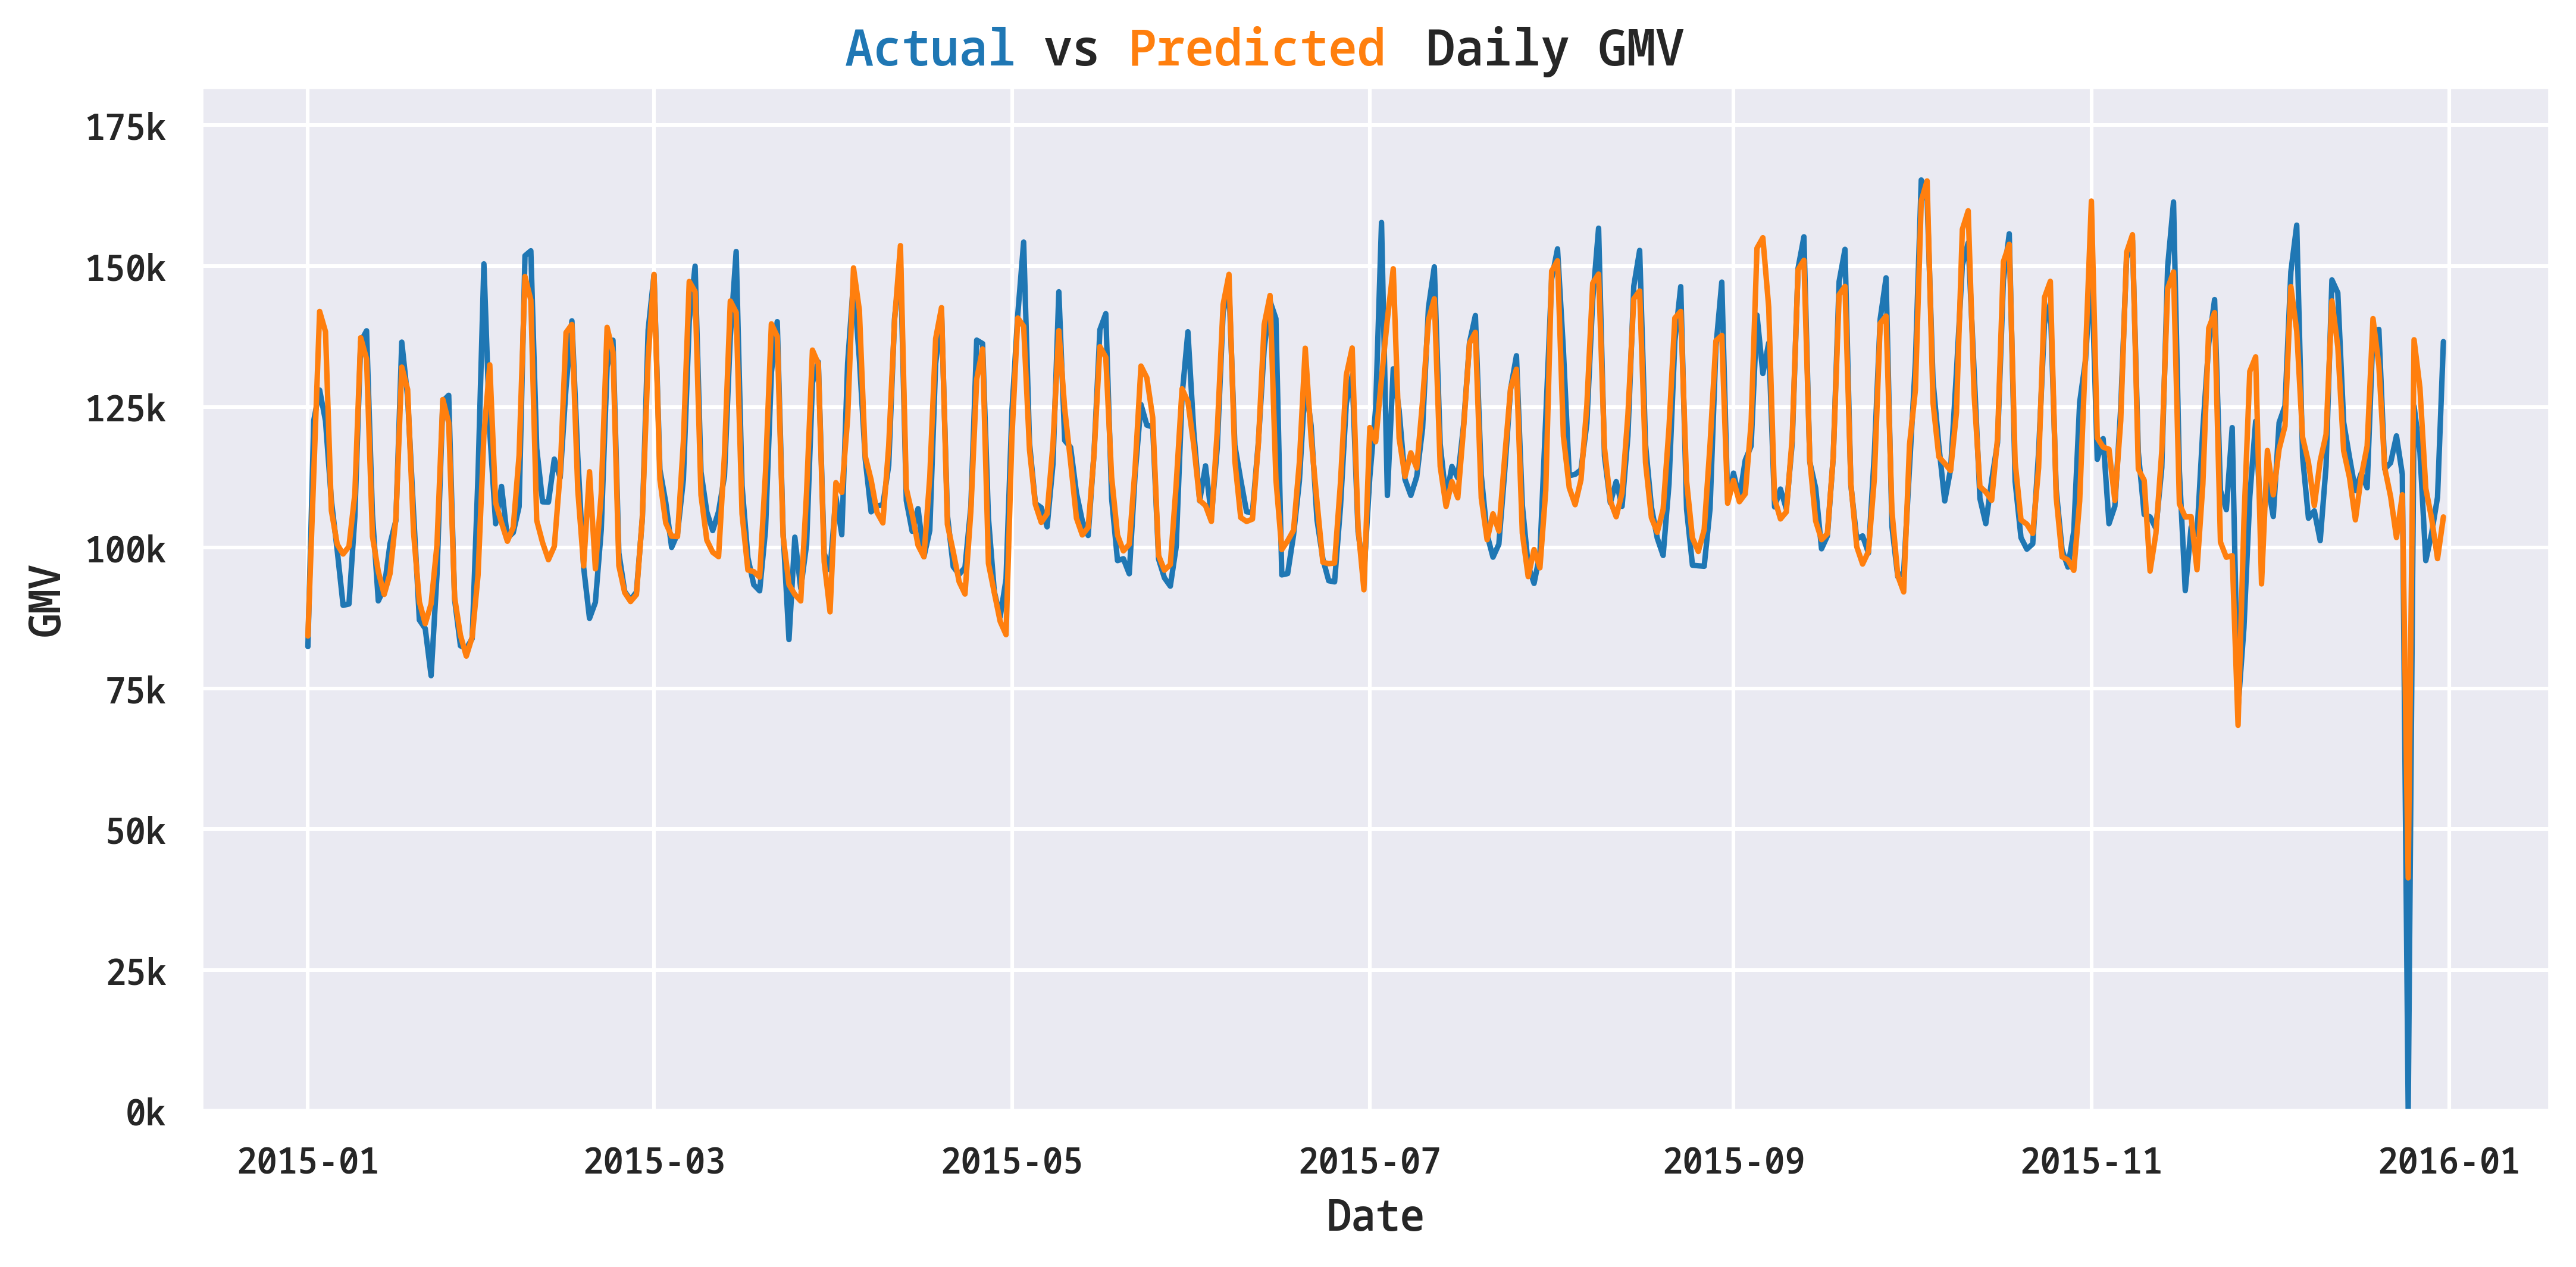

In [150]:
fig, ax = plt.subplots(
    figsize=(10, 5),
    dpi=440
)

actual_gmv_color = '#1f77b4'  # Default seaborn blue
predicted_gmv_color = '#ff7f0e'  # Default seaborn orange

ax.set_ylim(0, viz_df['daily_gmv'].max() * 1.1)

sns.lineplot(
    data=viz_df,
    x='date',
    y='daily_gmv',
    color=actual_gmv_color,
    ax=ax,
)

sns.lineplot(
    data=viz_df,
    x='date',
    y='predicted_daily_gmv',
    color=predicted_gmv_color,
    ax=ax,
)

# Title
text_properties = {
    'x': 0,
    'y': 0,
    'ha': 'left',
    'va': 'bottom',
    'fontsize': 14,
        }

t1 = ax.text(
        s='Actual',
        color=actual_gmv_color,
        **text_properties
        )

t2 = ax.text(
        s='vs',
        **text_properties
        )

t3 = ax.text(
        s='Predicted',
        color=predicted_gmv_color,
        **text_properties
        )

t4 = ax.text(
        s='Daily GMV',
        **text_properties
        )

dummy_title = ax.set_title('Daily GMV vs Predicted Daily GMV', fontsize=14)

title_coords = get_text_coordinates(dummy_title, ax, fig)
dummy_title.set_visible(False)

x = title_coords['x0']
y = title_coords['y0']

t1.set_position((x, y))
x = get_text_coordinates(t1, ax, fig)['x1']
t2.set_position((x, y))
x = get_text_coordinates(t2, ax, fig)['x1'] + 3  # small offset
t3.set_position((x, y))
x = get_text_coordinates(t3, ax, fig)['x1']
t4.set_position((x, y))

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('GMV', fontsize=12)

# Set tick font size
ax.tick_params(axis='both', which='major', labelsize=10)

# hide legend
ax.legend_.remove()

# format the y axis to have 
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y / 1000)}k'))

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Actual vs Predicted Cumulative Daily GMV

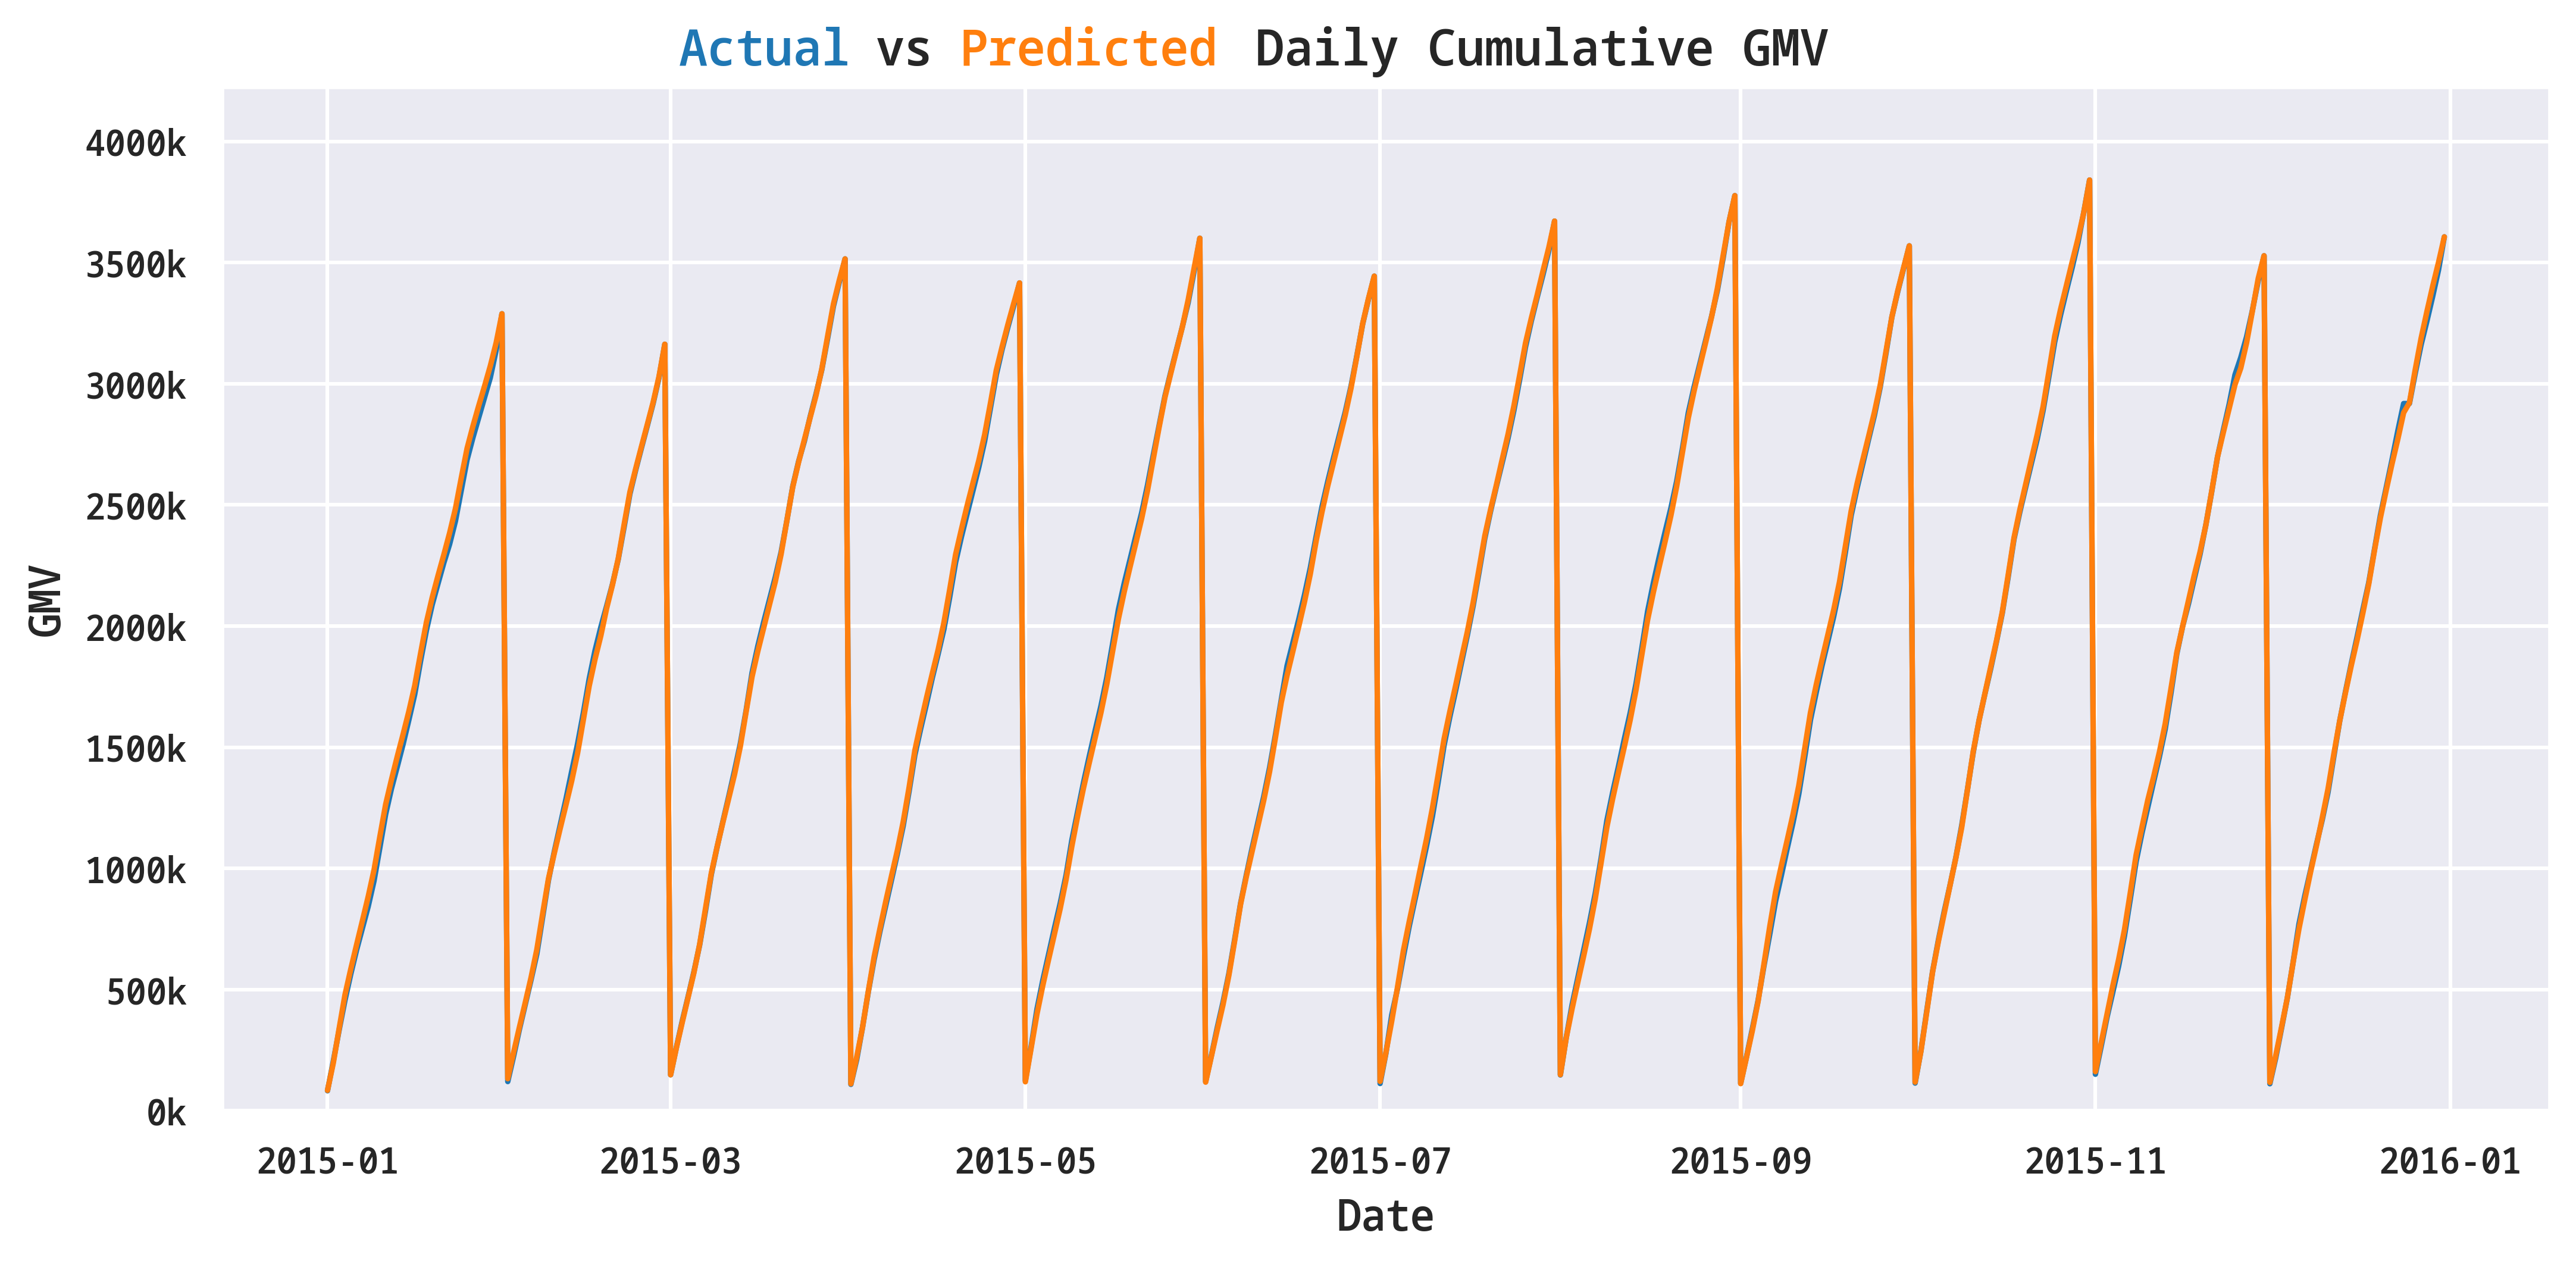

In [154]:
fig, ax = plt.subplots(
    figsize=(10, 5),
    dpi=440
)

actual_gmv_color = '#1f77b4'  # Default seaborn blue
predicted_gmv_color = '#ff7f0e'  # Default seaborn orange

ax.set_ylim(0, viz_df['daily_gmv_cumulative'].max() * 1.1)

sns.lineplot(
    data=viz_df,
    x='date',
    y='daily_gmv_cumulative',
    color=actual_gmv_color,
    ax=ax,
)

sns.lineplot(
    data=viz_df,
    x='date',
    y='predicted_daily_gmv_cumulative',
    color=predicted_gmv_color,
    ax=ax,
)

# Title
text_properties = {
    'x': 0,
    'y': 0,
    'ha': 'left',
    'va': 'bottom',
    'fontsize': 14,
        }

t1 = ax.text(
        s='Actual',
        color=actual_gmv_color,
        **text_properties
        )

t2 = ax.text(
        s='vs',
        **text_properties
        )

t3 = ax.text(
        s='Predicted',
        color=predicted_gmv_color,
        **text_properties
        )

t4 = ax.text(
        s='Daily Cumulative GMV',
        **text_properties
        )

dummy_title = ax.set_title('Daily GMV vs Predicted Daily Cumulative GMV', fontsize=14)

title_coords = get_text_coordinates(dummy_title, ax, fig)
dummy_title.set_visible(False)

x = title_coords['x0']
y = title_coords['y0']

t1.set_position((x, y))
x = get_text_coordinates(t1, ax, fig)['x1']
t2.set_position((x, y))
x = get_text_coordinates(t2, ax, fig)['x1'] + 3  # small offset
t3.set_position((x, y))
x = get_text_coordinates(t3, ax, fig)['x1']
t4.set_position((x, y))

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('GMV', fontsize=12)

# Set tick font size
ax.tick_params(axis='both', which='major', labelsize=10)

# hide legend
# ax.legend_.remove()

# format the y axis to have 
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y / 1000)}k'))

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion

The models appears quite accurate. It is mostly having trouble with large spikes and dips, but as we see from the visualization of the cumulative gmv, it evens out so it shouldn't be an issue.

We can safely use the model to adjust our monthly targets to a daily level and compare them with the actual metric to evaluate our progress.